<a href="https://colab.research.google.com/github/adriendod/Color_Classification/blob/master/Color_Classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import json
from keras.models import Sequential,Model,load_model
from keras.optimizers import SGD
from keras.layers import BatchNormalization, Lambda, Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation
from keras.layers.merge import Concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras.backend as K
from tensorboardcolab import *


!nvidia-smi

Using TensorFlow backend.


Thu May  2 14:38:39 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    17W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unzip "/content/gdrive/My Drive/Car_color_classification/data.zip" -d "/content"

Archive:  /content/gdrive/My Drive/Car_color_classification/data.zip
   creating: /content/data/
   creating: /content/data/green/
  inflating: /content/data/green/umg67ns1cv54aoz2xkdr.jpg  
  inflating: /content/data/green/byim7lft2jv4ekhsrwdu.jpg  
   creating: /content/__MACOSX/
   creating: /content/__MACOSX/data/
   creating: /content/__MACOSX/data/green/
  inflating: /content/__MACOSX/data/green/._byim7lft2jv4ekhsrwdu.jpg  
  inflating: /content/data/green/ybtf35gjrpme6o7hc2in.jpg  
  inflating: /content/__MACOSX/data/green/._ybtf35gjrpme6o7hc2in.jpg  
  inflating: /content/data/green/mlvyz8tr74xoph19fbqw.jpg  
  inflating: /content/data/green/6g5q34f0crzbwdkpa21n.jpg  
  inflating: /content/__MACOSX/data/green/._6g5q34f0crzbwdkpa21n.jpg  
  inflating: /content/data/green/yo6a5qrpkb3tzx1si09h.jpg  
  inflating: /content/data/green/hn2pqa04lzewoskjr9cm.jpg  
  inflating: /content/data/green/oi3aksqufv0chtm2ewdn.jpg  
  inflating: /content/__MACOSX/data/green/._oi3aksqufv0chtm2ewdn

In [0]:
def color_net(num_classes):
    # placeholder for input image
    input_image = Input(shape=(224,224,3))
    # ============================================= TOP BRANCH ===================================================
    # first top convolution layer
    top_conv1 = Convolution2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(224,224,3),activation='relu')(input_image)
    top_conv1 = BatchNormalization()(top_conv1)
    top_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_conv1)

    # second top convolution layer
    # split feature map by half
    top_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(top_conv1)
    top_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(top_conv1)

    top_top_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv2)
    top_top_conv2 = BatchNormalization()(top_top_conv2)
    top_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv2)

    top_bot_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv2)
    top_bot_conv2 = BatchNormalization()(top_bot_conv2)
    top_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv2)

    # third top convolution layer
    # concat 2 feature map
    top_conv3 = Concatenate()([top_top_conv2,top_bot_conv2])
    top_conv3 = Convolution2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_conv3)

    # fourth top convolution layer
    # split feature map by half
    top_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(top_conv3)
    top_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(top_conv3)

    top_top_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_bot_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)

    # fifth top convolution layer
    top_top_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_top_conv4)
    top_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_top_conv5) 

    top_bot_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(top_bot_conv4)
    top_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(top_bot_conv5)

    # ============================================= TOP BOTTOM ===================================================
    # first bottom convolution layer
    bottom_conv1 = Convolution2D(filters=48,kernel_size=(11,11),strides=(4,4),
                              input_shape=(224,224,3),activation='relu')(input_image)
    bottom_conv1 = BatchNormalization()(bottom_conv1)
    bottom_conv1 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_conv1)

    # second bottom convolution layer
    # split feature map by half
    bottom_top_conv2 = Lambda(lambda x : x[:,:,:,:24])(bottom_conv1)
    bottom_bot_conv2 = Lambda(lambda x : x[:,:,:,24:])(bottom_conv1)

    bottom_top_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv2)
    bottom_top_conv2 = BatchNormalization()(bottom_top_conv2)
    bottom_top_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv2)

    bottom_bot_conv2 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv2)
    bottom_bot_conv2 = BatchNormalization()(bottom_bot_conv2)
    bottom_bot_conv2 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv2)

    # third bottom convolution layer
    # concat 2 feature map
    bottom_conv3 = Concatenate()([bottom_top_conv2,bottom_bot_conv2])
    bottom_conv3 = Convolution2D(filters=192,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_conv3)

    # fourth bottom convolution layer
    # split feature map by half
    bottom_top_conv4 = Lambda(lambda x : x[:,:,:,:96])(bottom_conv3)
    bottom_bot_conv4 = Lambda(lambda x : x[:,:,:,96:])(bottom_conv3)

    bottom_top_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_bot_conv4 = Convolution2D(filters=96,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)

    # fifth bottom convolution layer
    bottom_top_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_top_conv4)
    bottom_top_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_top_conv5) 

    bottom_bot_conv5 = Convolution2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(bottom_bot_conv4)
    bottom_bot_conv5 = MaxPooling2D(pool_size=(3,3),strides=(2,2))(bottom_bot_conv5)

    # ======================================== CONCATENATE TOP AND BOTTOM BRANCH =================================
    conv_output = Concatenate()([top_top_conv5,top_bot_conv5,bottom_top_conv5,bottom_bot_conv5])

    # Flatten
    flatten = Flatten()(conv_output)

    # Fully-connected layer
    FC_1 = Dense(units=4096, activation='relu')(flatten)
    FC_1 = Dropout(0.6)(FC_1)
    FC_2 = Dense(units=4096, activation='relu')(FC_1)
    FC_2 = Dropout(0.6)(FC_2)
    output = Dense(units=num_classes, activation='softmax')(FC_2)
    
    model = Model(inputs=input_image,outputs=output)
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    # sgd = SGD(lr=0.01, momentum=0.9, decay=0.0005, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['acc'])
    
    return model
  
  

In [0]:
# model config
img_rows , img_cols = 224,224
num_classes = 10
batch_size = 64
nb_epoch = 20
data_directory = "/content/data"

#setup TensorBoard
tbc=TensorBoardColab()

# initialise model
model = color_net(num_classes)
print(model.summary())

Wait for 8 seconds...
TensorBoard link:
https://2249628f.ngrok.io
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 54, 54, 48)   17472       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 54, 54, 48)   17472       input_1[0][0]                    
______________________________________________________

In [0]:
filepath = 'color_weights.hdf5'
checkpoint = TensorBoardColabCallback(tbc)
callbacks_list = [checkpoint]

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
        validation_split=0.2)


training_set = train_datagen.flow_from_directory(
            data_directory,
            target_size=(img_rows, img_cols),
            batch_size=batch_size,
            class_mode='categorical',
            subset = 'training')

test_set = train_datagen.flow_from_directory(
            data_directory,
            target_size=(img_rows, img_cols),
            batch_size=batch_size,
            class_mode='categorical',
            subset = 'validation')



Found 34804 images belonging to 10 classes.
Found 8695 images belonging to 10 classes.


In [0]:
#Fitting model

history = model.fit_generator(
        training_set,
        steps_per_epoch=500,
        epochs=nb_epoch,
        validation_data=test_set,
        validation_steps=250,
        callbacks=callbacks_list)

model.save('/content/gdrive/My Drive/Car_color_classification/color_model.h5')
with open('/content/gdrive/My Drive/Car_color_classification/history.json', 'w') as f:
    json.dump(history.history, f)


Instructions for updating:
Use tf.cast instead.
Epoch 1/20
500/500 [==============================] - 733s 1s/step - loss: 1.1330 - acc: 0.6298 - val_loss: 0.9540 - val_acc: 0.6845
Epoch 2/20
500/500 [==============================] - 706s 1s/step - loss: 0.7469 - acc: 0.7444 - val_loss: 0.7289 - val_acc: 0.7590
Epoch 3/20
500/500 [==============================] - 702s 1s/step - loss: 0.6040 - acc: 0.7916 - val_loss: 0.6055 - val_acc: 0.8029
Epoch 4/20
500/500 [==============================] - 697s 1s/step - loss: 0.5281 - acc: 0.8219 - val_loss: 0.5795 - val_acc: 0.8052
Epoch 5/20
500/500 [==============================] - 706s 1s/step - loss: 0.4715 - acc: 0.8413 - val_loss: 0.5106 - val_acc: 0.8283
Epoch 6/20
500/500 [==============================] - 705s 1s/step - loss: 0.4465 - acc: 0.8516 - val_loss: 0.5690 - val_acc: 0.8119
Epoch 7/20
500/500 [==============================] - 715s 1s/step - loss: 0.4185 - acc: 0.8608 - val_loss: 0.4066 - val_acc: 0.8651
Epoch 8/20
500/500 [=

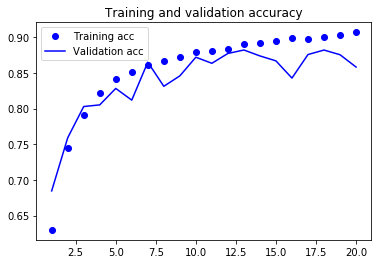

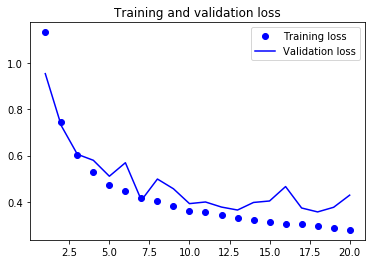

In [0]:
#plotting results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
#Loading model
model = load_model('/content/gdrive/My Drive/Car_color_classification/color_model.h5')


#Confution Matrix and Classification Report

test_set_CM = train_datagen.flow_from_directory(
            data_directory,
            target_size=(img_rows, img_cols),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False,
            subset = 'validation')

Y_pred = model.predict_generator(test_set_CM, 136)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_set_CM.classes, y_pred))
print('Classification Report')
target_names = ['black', 'blue', 'cyan', 'green', 'grey_light', 'grey_other', 'notACar', 'red', 'white', 'yellow']
print(classification_report(test_set_CM.classes, y_pred, target_names=target_names))

Found 8695 images belonging to 10 classes.
Confusion Matrix
[[2453   79    1    1   17  106   77   10   31    0]
 [  32  560    3    2    2    7    2    4    8    1]
 [   0    0   54    0    0    0    0    0    2    0]
 [  21    5    0  104    3    7    8    0    8    2]
 [   5   11    1    0  478   15   14    1  291    1]
 [  55   35    0    1  138  223   15    4   12    1]
 [   2    3    0    1    6    4  388    7   14    0]
 [   3    1    0    1    2    4   21 1202    2    2]
 [   8    2    0    0   25    3   38    4 1812    0]
 [   0    1    0    2    0    1    4    6   24  191]]
Classification Report
              precision    recall  f1-score   support

       black       0.95      0.88      0.92      2775
        blue       0.80      0.90      0.85       621
        cyan       0.92      0.96      0.94        56
       green       0.93      0.66      0.77       158
  grey_light       0.71      0.59      0.64       817
  grey_other       0.60      0.46      0.52       484
     not

Text(0.5, 41.09375, 'Predicted label')

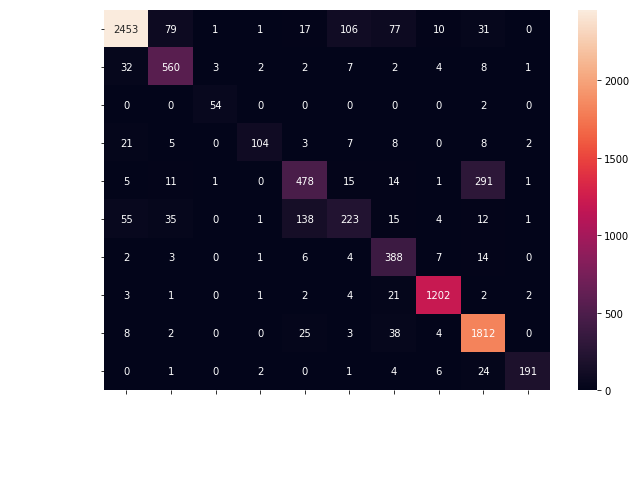

In [0]:
cm = confusion_matrix(test_set_CM.classes, y_pred)

df_cm = pd.DataFrame(cm, index=target_names, columns=target_names)

  
fig = plt.figure(figsize = (10,7))
    
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14, color="white")
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14, color="white")
plt.ylabel('True label', color="white")
plt.xlabel('Predicted label', color="white")


Text(0.5, 41.09375, 'Predicted label')

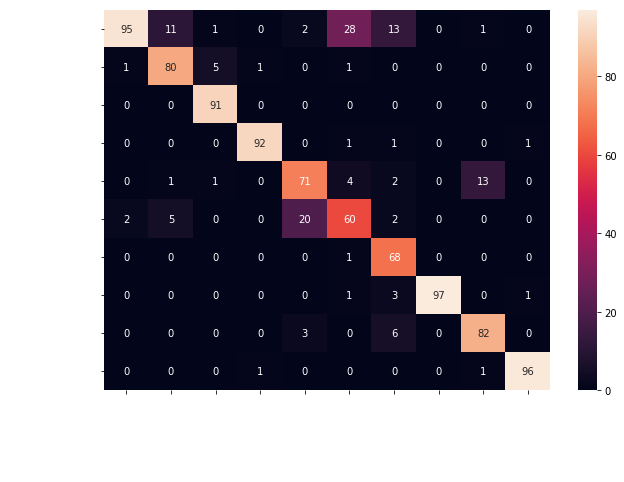

In [0]:
df_cm_percent = df_cm.copy()

for i in df_cm:
  for j in range(0, len(df_cm)):
    df_cm_percent[i][j] = df_cm[i][j] / df_cm[i].sum() * 100
  
fig = plt.figure(figsize = (10,7))
    
heatmap = sns.heatmap(df_cm_percent, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14, color="white")
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14, color="white")
plt.ylabel('True label', color="white")
plt.xlabel('Predicted label', color="white")


In [0]:
!cd

model = load_model("/gdrive/My Drive/Car_color_classification/color_model2.h5")
classes = training_set.class_indices
colors = ["black", "blue", "cyan", "green", "grey-light", "grey-other", "notACar", "red", "white", "yellow"]
df = pd.DataFrame(columns=colors)

def model_test(color):
    path = "/content/data/" + color + "/"
    i = 0
    for img in os.listdir(path):
      if img.lower().endswith(('.png', '.jpg', '.jpeg')) : 
        img = image.load_img(path + img, target_size=(224, 224))
        img = image.img_to_array(img)
        img = img/255
        img = img.reshape(1,224,224,3)
        prediction = model.predict(img)
        prediction = prediction.argmax(axis=-1)
        df.loc[i,color] = prediction[0]
        i += 1

for color in colors :
  model_test(color)
  

      

In [0]:
df.head()

black blue cyan green grey-light grey-other notACar red white yellow
0     0    1    2     3          4          5       6   7     8      9
1     0    1    2     3          8          0       6   7     8      8
2     0    1    2     0          4          5       6   7     8      9
3     0    0    2     3          4          5       6   7     8      9
4     0    5    2     3          4          0       6   7     8      9